# CV to detect steel defects
- Data source: https://www.kaggle.com/datasets/sovitrath/neu-steel-surface-defect-detect-trainvalid-split/data?select=valid_images
- Size of dataset: 1800 images, with .xml files for indexing, e.g. ['crazing', (10, 50, 60, 100)]
- Resolution: 200 x 200 pixels
- Defects: 6 types of defects
    - Crazing
    - Inclusion
    - Patches
    - Rolled-in scale
    - Pitted surface
    - Scratches

## 1. Import libraries

In [10]:
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

## 2. Functions
### 2.1 load_dataset()

In [11]:
def load_dataset(images_folder, annotations_folder):
    """Load all images and annotations from folders."""
    image_files = sorted([f for f in os.listdir(images_folder) if f.endswith('.jpg')])
    
    dataset = []
    for img_file in image_files:
        xml_file = img_file.replace('.jpg', '.xml')
        img_path = os.path.join(images_folder, img_file)
        xml_path = os.path.join(annotations_folder, xml_file)
        
        if os.path.exists(xml_path):
            dataset.append({'image': img_path, 'annotation': xml_path})
    
    print(f"Loaded {len(dataset)} images with annotations")
    return dataset

Quick test:

In [12]:
images_folder, annotations_folder = "/Users/litani/Documents/myCode/steel-defects/data/raw/train_images", "/Users/litani/Documents/myCode/steel-defects/data/raw/train_annotations"
dataset = load_dataset(images_folder, annotations_folder)

Loaded 1700 images with annotations


### 2.1 ```parse_xml(xml_path)```
- **Objective:** extracts bounding box (BB) coordinates from XML
- **Method:** Navigates XML tree → finds all ```<object>``` tags → extracts ```<name>``` (label, e.g., crazing) and ```<bndbox>``` coordinates
- **Output:** list of dictionary with label and coordinates (x_min,y_min,x_max,y_max)

In [13]:
def parse_xml(xml_path):
    """Parse XML annotation file and extract bounding boxes."""
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    boxes = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        boxes.append({'label': label, 'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax})
    
    return boxes

Quick test:

In [14]:
xml_path = "/Users/litani/Documents/myCode/steel-defects/data/raw/train_annotations/crazing_2.xml"
parse_xml(xml_path)

[{'label': 'crazing', 'xmin': 99, 'ymin': 120, 'xmax': 200, 'ymax': 174},
 {'label': 'crazing', 'xmin': 8, 'ymin': 16, 'xmax': 200, 'ymax': 111}]

### 2.2 ```image_viz_bb(image_path, xml_path)```
- **Objective:** displays 1 image w/ its BBs
- **Method:** loads image → gets BBs from ```parse_xml()``` → creates ```matplotlib``` fig. → draws rectangles at BBs >>> adds text labels above BBs
- **Output:** BBs are drawn on the image axes using ```<patches.Rectangle>```

In [15]:
def image_viz_bb(img_path, xml_path):
    """Display image with bounding boxes from XML annotation."""
    img = Image.open(img_path)
    boxes = parse_xml(xml_path)
    
    fig, ax = plt.subplots(1, figsize = (5, 5))
    ax.imshow (img)
    
    for box in boxes:
        width = box["xmax"] - box["xmin"]
        height = box["ymax"] - box["ymin"]
        rect = patches.Rectangle((box["xmin"], box["ymin"]), width, height, 
                                linewidth = 2, edgecolor = "red", facecolor = "none")
        ax.add_patch(rect)
        ax.text(box["xmin"], box["ymin"] - 5, box["label"], 
                color = "red", fontsize = 10, weight = "bold")
    
    ax.axis("on")
    plt.tight_layout()
    plt.show()


Quick test:

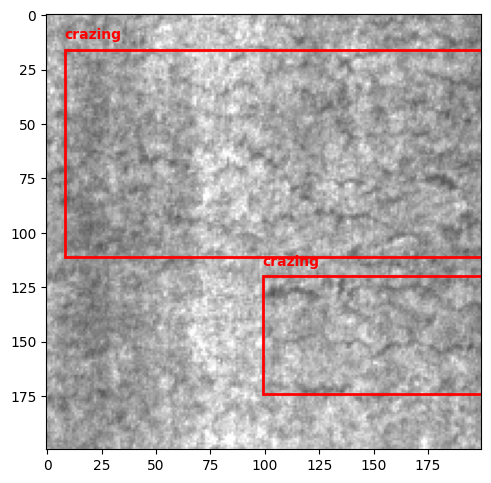

In [16]:
img_path = "/Users/litani/Documents/myCode/steel-defects/data/raw/train_images/crazing_2.jpg"

image_viz_bb(img_path, xml_path)

### 2.3 ```viz_grid(dataset, num_images = 4, cols = 2):```

In [17]:
def viz_grid(dataset, num_images, cols):
    """Display multiple images with bounding boxes in a grid."""
    rows = (num_images + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize = (8, 5 * rows))
    axes = axes.flatten() if num_images > 1 else [axes]
    
    for idx in range(num_images):
        if idx < len(dataset):
            img = Image.open(dataset[idx]["image"])
            boxes = parse_xml(dataset[idx]["annotation"])
            
            axes[idx].imshow(img)
            for box in boxes:
                width = box["xmax"] - box["xmin"]
                height = box["ymax"] - box["ymin"]
                rect = patches.Rectangle((box["xmin"], box["ymin"]), width, height,
                                        linewidth = 2, edgecolor = "red", facecolor = "none")
                axes[idx].add_patch(rect)
                axes[idx].text(box["xmin"], box["ymin"] - 5, box["label"],
                            color = "red", fontsize = 10, weight = "bold")
            axes[idx].axis("on")
            axes[idx].set_title(os.path.basename(dataset[idx]["image"]))
        else:
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

Quick test:

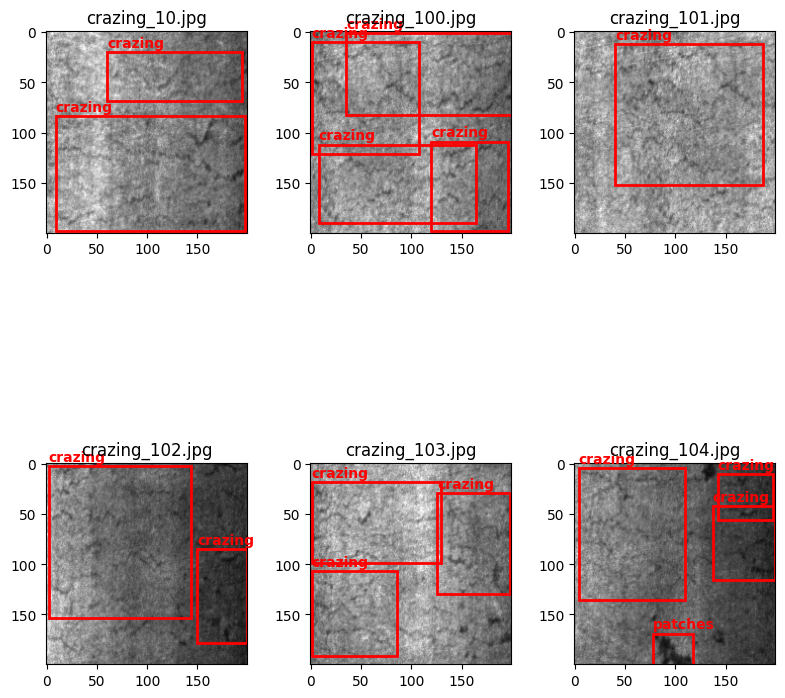

In [18]:
viz_grid(dataset, num_images = 6, cols = 3)